In [261]:
# 기술 출처 : owards Context-aware Automatic Haptic Effect Generation for Home Theatre Environments

In [262]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

(4410000,)
100.0


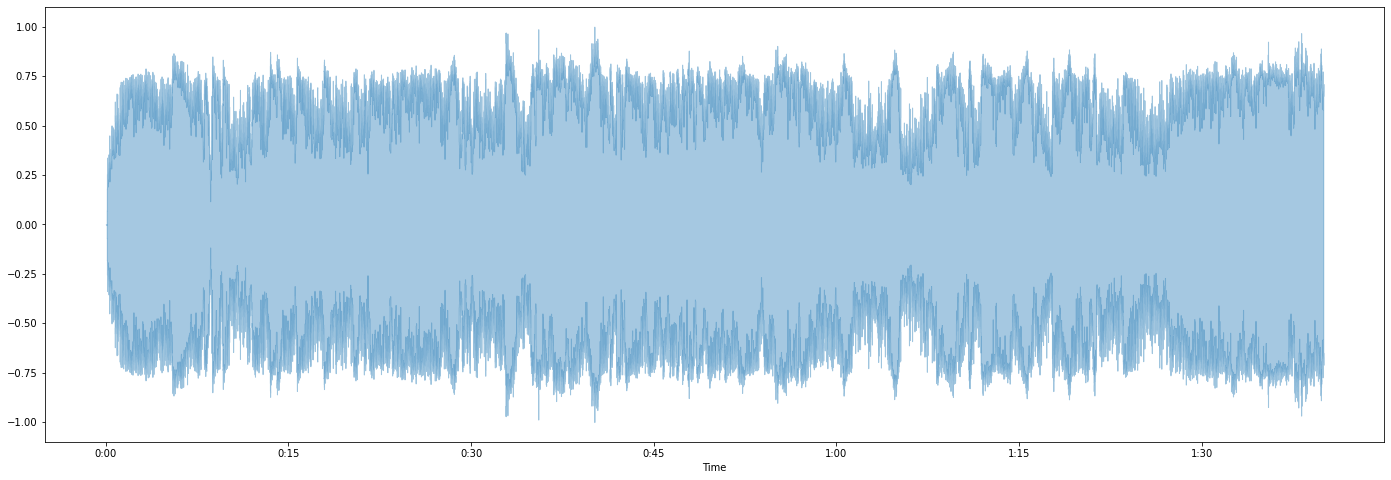

In [263]:
file_name = "맨오브스틸 - 슈퍼맨 vs 조드 명장면.mp3"
sample_rate = 44100
start_sec = 0
end_sec = 100

audio, _ = librosa.load(file_name, sr=sample_rate)
audio = audio[(sample_rate*start_sec):(sample_rate*end_sec)]

max_amplitude = 1.0
min_amplitude = -1.0

max_value = np.max(np.abs(audio))

if max_value > 0 :
    audio = audio * (max_amplitude / max_value)

print(audio.shape)
print(int(audio.shape[0]) / sample_rate)
plt.figure(figsize=(24, 8))
librosa.display.waveshow(audio, sr=sample_rate, alpha=0.4)

In [264]:
# bark 계산
def get_bark_from_freq(freq: int):
    return 7 * np.arcsinh(freq / 600)

# freq 계산
def get_freq_from_bark(bark: float):
    return 600 * np.sinh(bark / 7)

print(get_freq_from_bark(0.3)) # 25.722158157347017
print(get_freq_from_bark(24)) # 9240.039453276086
print(get_freq_from_bark(0.49529)) # 42.488860375848695

print(get_bark_from_freq(26)) # 0.30323848136264453
print(get_bark_from_freq(9240)) # 23.9999701740334
print(get_bark_from_freq(43)) # 0.5012382202199146

# 26 ~ 9240 hz 사용

25.722158157347017
9240.039453276086
42.488860375848695
0.30323848136264453
23.9999701740334
0.5012382202199146


In [265]:
# adaptive threshold algorithm
def get_adaptive_threshold(values):
    #multiple = 1.6449
    multiple = 4 # 상황에 맞게 수정
    length = 5168 # 30초에 2584 # 60초에 5168
    thresholds = np.array([ (sum(values[i-length+1:i]) if i-length+1 >= 0 else sum(list(values[i-length+1:]) + list(values[:i]))) / length for i in range(0, len(values)) ]) \
               + multiple * np.array([ (np.std(values[i-length+1:i]) if i-length+1 >= 0 else np.std(list(values[i-length+1:]) + list(values[:i]))) for i in range(0, len(values))])
    return thresholds

[0.0000000e+00 0.0000000e+00 8.4320757e-26 ... 2.6405668e-01 2.3360063e-01
 1.6317187e-01]
(8614,)


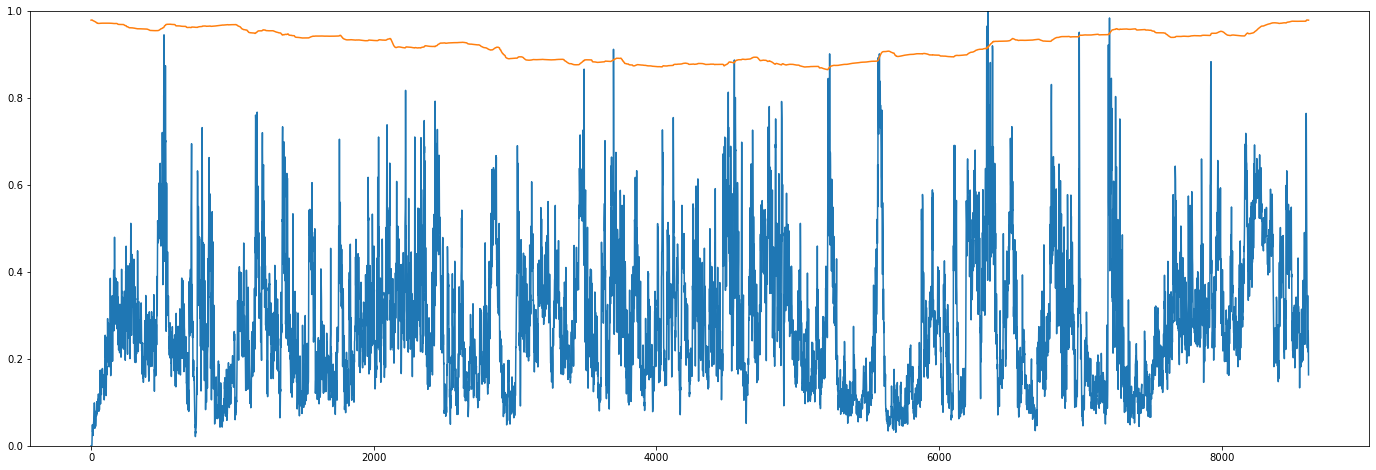

In [266]:
# Intensity (in generally)
feature = librosa.stft(audio, n_fft=2048)

feature = np.abs(feature) ** 2 # power spectrogram
intensity = np.sum(feature, axis=0)

max_intensity = 1.0
min_intensity = -1.0

max_value = np.max(np.abs(intensity))

if max_value > 0 :
    intensity = intensity * (max_intensity / max_value)
    
print(intensity)
print(intensity.shape)

thresholds = get_adaptive_threshold(intensity)

plt.figure(figsize=(24, 8))
plt.ylim(0, 1)
plt.plot(intensity)
plt.plot(thresholds)

C:\Users\devtae\anaconda3\lib\site-packages\librosa\core\convert.py:1332: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


[0.00000000e+00 0.00000000e+00 4.46838274e-28 ... 1.07080377e-01
 4.04928571e-02 1.83338497e-02]
(8614,)


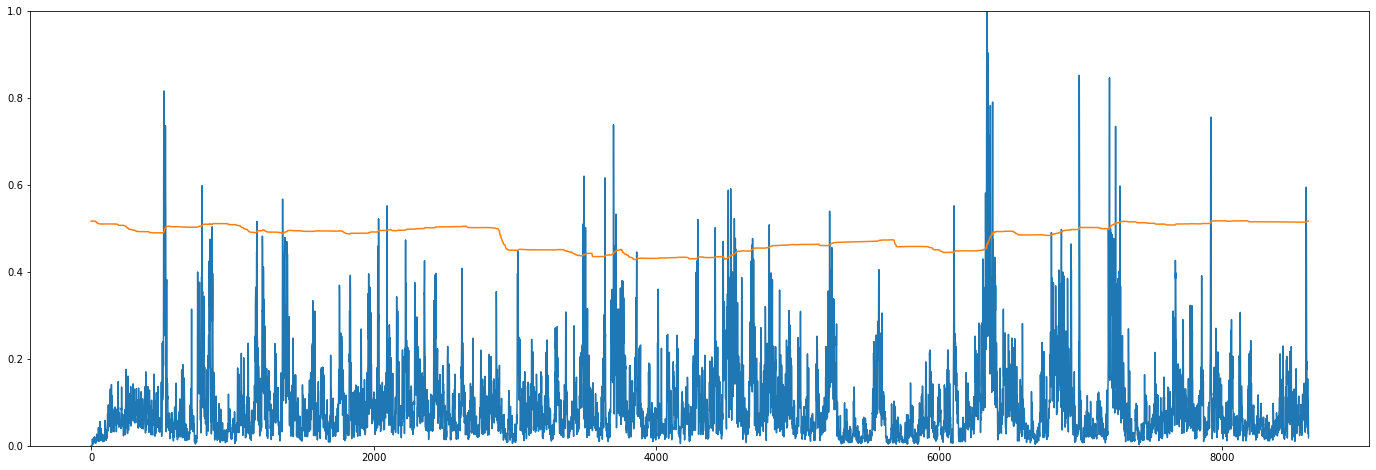

In [267]:
# Loudness
n_fft = 2048
frequency_range = (26, 9240)

feature = librosa.stft(audio, n_fft=n_fft)

# 주파수 범위 선택
freq_bins = librosa.fft_frequencies(sr=sample_rate, n_fft=n_fft)
freq_indices = np.where((freq_bins >= frequency_range[0]) & (freq_bins <= frequency_range[1]))[0]
feature = feature[freq_indices, :]

# A-weighting 적용
a_weighting = librosa.A_weighting(freq_bins)
loudness = feature * a_weighting[freq_indices, np.newaxis]

loudness = np.abs(loudness) ** 2 # power of loudness
loudness = np.sum(loudness, axis=0)

max_loudness = 1.0
min_loudness = -1.0
max_value = np.max(np.abs(loudness))

if max_value > 0:
    loudness = loudness * (max_loudness / max_value)

print(loudness)
print(loudness.shape)

thresholds = get_adaptive_threshold(loudness)

plt.figure(figsize=(24, 8))
plt.ylim(0, 1)
plt.plot(loudness)
plt.plot(thresholds)

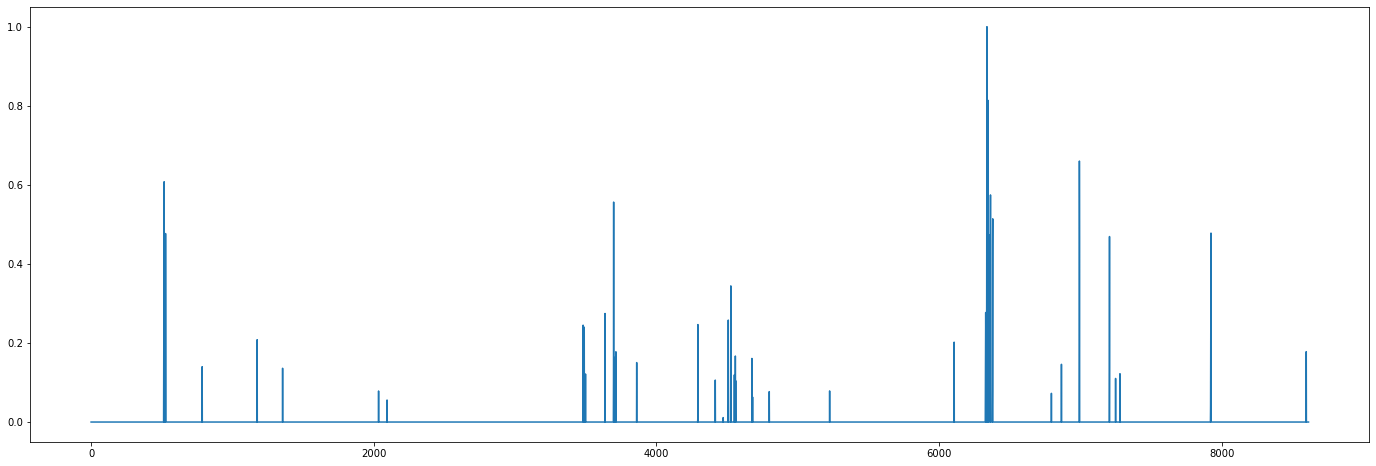

In [269]:
# thresholds 상회값
thresholds_active = [ 1 if loudness[i] >= thresholds[i] else 0 for i in range(len(thresholds))]
# 표준편차 미분값 (가파른 정도 / 강력한 소리의 여부)
thresholds_derivative = [ (thresholds[i] - thresholds[i-1]) * thresholds_active[i] for i in range(len(thresholds))]
thresholds_derivative = [ threshold if threshold > 0 else 0 for threshold in thresholds_derivative ]

max_thresholds_derivative = 1.0
min_thresholds_derivative = 0
max_value = np.max(np.abs(thresholds_derivative))

if max_value > 0:
    audio_event_results = np.array(thresholds_derivative) * (max_thresholds_derivative / max_value)

plt.figure(figsize=(24, 8))
plt.plot(audio_event_results)

In [284]:
# 진동 강도 정의
def get_level(value):

    if 0 < value and value < 0.33:
        return 1
    elif 0.33 <= value and value < 0.66:
        return 2
    else:
        return 3
    
# 변환된 프레임을 바탕으로 타임스탬프 값 구하기
def get_timestamp(start_sec, end_sec, frames, i):
    return start_sec + (end_sec - start_sec) / frames * i


frames = loudness.shape[0]

i = 0
while i < len(audio_event_results):
    if audio_event_results[i] > 0 and audio_event_results[i-1] == 0:
        print("[Event Detector]", round(get_timestamp(start_sec, end_sec, frames, i), 1), "초에", get_level(max(audio_event_results[i:i+100])), "단계의 이벤트가 감지되었습니다.")
        i += 100 # 약 1 초 단위로 이벤트를 나눔
    else:
        i += 1
        

[Event Detector] 6.0 초에 2 단계의 이벤트가 감지되었습니다.
[Event Detector] 9.1 초에 1 단계의 이벤트가 감지되었습니다.
[Event Detector] 13.6 초에 1 단계의 이벤트가 감지되었습니다.
[Event Detector] 15.7 초에 1 단계의 이벤트가 감지되었습니다.
[Event Detector] 23.6 초에 1 단계의 이벤트가 감지되었습니다.
[Event Detector] 40.4 초에 1 단계의 이벤트가 감지되었습니다.
[Event Detector] 42.2 초에 2 단계의 이벤트가 감지되었습니다.
[Event Detector] 44.8 초에 1 단계의 이벤트가 감지되었습니다.
[Event Detector] 49.8 초에 1 단계의 이벤트가 감지되었습니다.
[Event Detector] 51.3 초에 1 단계의 이벤트가 감지되었습니다.
[Event Detector] 52.5 초에 2 단계의 이벤트가 감지되었습니다.
[Event Detector] 54.3 초에 1 단계의 이벤트가 감지되었습니다.
[Event Detector] 55.7 초에 1 단계의 이벤트가 감지되었습니다.
[Event Detector] 60.7 초에 1 단계의 이벤트가 감지되었습니다.
[Event Detector] 70.9 초에 1 단계의 이벤트가 감지되었습니다.
[Event Detector] 73.5 초에 3 단계의 이벤트가 감지되었습니다.
[Event Detector] 78.9 초에 1 단계의 이벤트가 감지되었습니다.
[Event Detector] 81.1 초에 3 단계의 이벤트가 감지되었습니다.
[Event Detector] 83.6 초에 2 단계의 이벤트가 감지되었습니다.
[Event Detector] 91.9 초에 2 단계의 이벤트가 감지되었습니다.
[Event Detector] 99.8 초에 1 단계의 이벤트가 감지되었습니다.


In [ ]:
"""
[Event Detector] 6.0 초에 2 단계의 이벤트가 감지되었습니다.
 -> 슈퍼맨이 날라가서 쇠파이프에 부딪히는 소리

[Event Detector] 9.1 초에 1 단계의 이벤트가 감지되었습니다.
 -> 슈퍼맨이 배트맨 복부를 발차기로 가격하는 소리

[Event Detector] 13.6 초에 1 단계의 이벤트가 감지되었습니다.
 -> 슈퍼맨이 배트맨 강하게 치는 소리 1

[Event Detector] 15.7 초에 1 단계의 이벤트가 감지되었습니다.
 -> 슈퍼맨이 배트맨 강하게 치는 소리 2

[Event Detector] 23.6 초에 1 단계의 이벤트가 감지되었습니다.
 -> 배경음악 북소리
 
 --- 유리 깨지는 소리 인지 못함 --- 
  - loudness waveform 분석해보니 유리 깨지는 것을 잘 인식 못함
    -> 반영 필요

[Event Detector] 40.4 초에 1 단계의 이벤트가 감지되었습니다.
 -> 건물 무너지는 소리

[Event Detector] 42.2 초에 2 단계의 이벤트가 감지되었습니다.
 -> 슈퍼맨 맞는 소리

[Event Detector] 44.8 초에 1 단계의 이벤트가 감지되었습니다.
 -> 배트맨이 슈퍼맨 돌리는 소리

[Event Detector] 49.8 초에 1 단계의 이벤트가 감지되었습니다.
 -> 슈퍼맨이 건물로 관통되는 소리 1

[Event Detector] 51.3 초에 1 단계의 이벤트가 감지되었습니다.
 -> 슈퍼맨이 건물로 관통되는 소리 2

[Event Detector] 52.5 초에 2 단계의 이벤트가 감지되었습니다.
 -> 슈퍼맨이 건물로 관통되는 소리 3

[Event Detector] 54.3 초에 1 단계의 이벤트가 감지되었습니다.
 -> 슈퍼맨이 건물로 관통되는 소리 4

[Event Detector] 55.7 초에 1 단계의 이벤트가 감지되었습니다.
 -> 슈퍼맨이 건물로 관통되는 소리 5

[Event Detector] 60.7 초에 1 단계의 이벤트가 감지되었습니다.
 -> 배트맨이 슈퍼맨을 치는 소리

[Event Detector] 70.9 초에 1 단계의 이벤트가 감지되었습니다.
 -> 달에서 우주선을 잡으며 착륙하는 소리

[Event Detector] 73.5 초에 3 단계의 이벤트가 감지되었습니다.
 -> 우주선이 날라오는 소리 (저음역대로 보임)

[Event Detector] 78.9 초에 1 단계의 이벤트가 감지되었습니다.
 -> 우주선 부서지는 소리

[Event Detector] 81.1 초에 3 단계의 이벤트가 감지되었습니다.
 -> 슈퍼맨 강하게 맞는 소리 (이후 지구로 떨어짐)

[Event Detector] 83.6 초에 2 단계의 이벤트가 감지되었습니다.
 -> 폭발 소리

[Event Detector] 91.9 초에 2 단계의 이벤트가 감지되었습니다.
 -> 달에서 지구로 날라오면서 건물 뚫리는 소리

 --- 슈퍼맨이 소리지르는 소리는 이벤트 감지하지 않았음 ---

[Event Detector] 99.8 초에 1 단계의 이벤트가 감지되었습니다.
 -> 건물 바닥에 떨어지는 소리

"""
